In this notebook, we'll evaluate all of the trained models: benchmarking their performance, analyzing feature attributions, and identifying where each model succeeds or fails across the dataset in the process. We trained and evaluated all of the models using one train-test split, while hyperparameter tuning was performed using 5-fold cross validation.

# Performance Comparison

Let's start out by importing the libraries we'll need, as well as the model results so we can compare them against each other. We'll start out by defining the filenames for the model_results, and then loading them into a dictionary that we can reference. We'll be converting the dictionary to a DataFrame for ease of access.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run model_utils.ipynb

In [2]:
filenames_stats = {
    'logistic_regression': 'model_results/logistic_regression.pkl',
    'logistic_regression_tuned': 'model_results/logistic_regression_tuned.pkl',
    'svc': 'model_results/svc.pkl',
    'svc_tuned': 'model_results/svc_tuned.pkl',
    'random_forest': 'model_results/random_forest.pkl',
    'random_forest_tuned': 'model_results/random_forest_tuned.pkl',
    'adaboost': 'model_results/adaboost.pkl',
    'adaboost_tuned': 'model_results/adaboost_tuned.pkl',
    'gradient_boosting': 'model_results/gradient_boosting.pkl',
    'gradient_boosting_tuned': 'model_results/gradient_boosting_tuned.pkl',
}

In [3]:
model_results = {}

for file_name, path in filenames_stats.items():
    with open(path, 'rb') as f:
        model_results[file_name] = pickle.load(f)

In [4]:
df_results = pd.DataFrame(model_results).transpose().reset_index(drop=True)

In [5]:
df_results

,model,accuracy,precision,recall,f1_score
0,Logistic Regression (Untuned),0.72224,0.754842,0.641717,0.693698
1,Logistic Regression (Tuned),0.722485,0.755386,0.64155,0.69383
2,Support Vector Classifier (Untuned),0.728762,0.758322,0.655522,0.703185
3,Support Vector Classifier (Tuned),0.72917,0.759753,0.654358,0.703128
4,Random Forest (Untuned),0.6955,0.693195,0.679474,0.686266
5,Random Forest (Tuned),0.727213,0.750094,0.665003,0.70499
6,AdaBoost (Untuned),0.719468,0.754908,0.633234,0.688738
7,AdaBoost (Tuned),0.716289,0.748723,0.633899,0.686543
8,Gradient Boosting (Untuned),0.727621,0.741109,0.682801,0.710761
9,Gradient Boosting (Tuned),0.727703,0.741591,0.682136,0.710622


Now that we have a DataFrame with the metrics of each of the models, let's plot each metric individually.


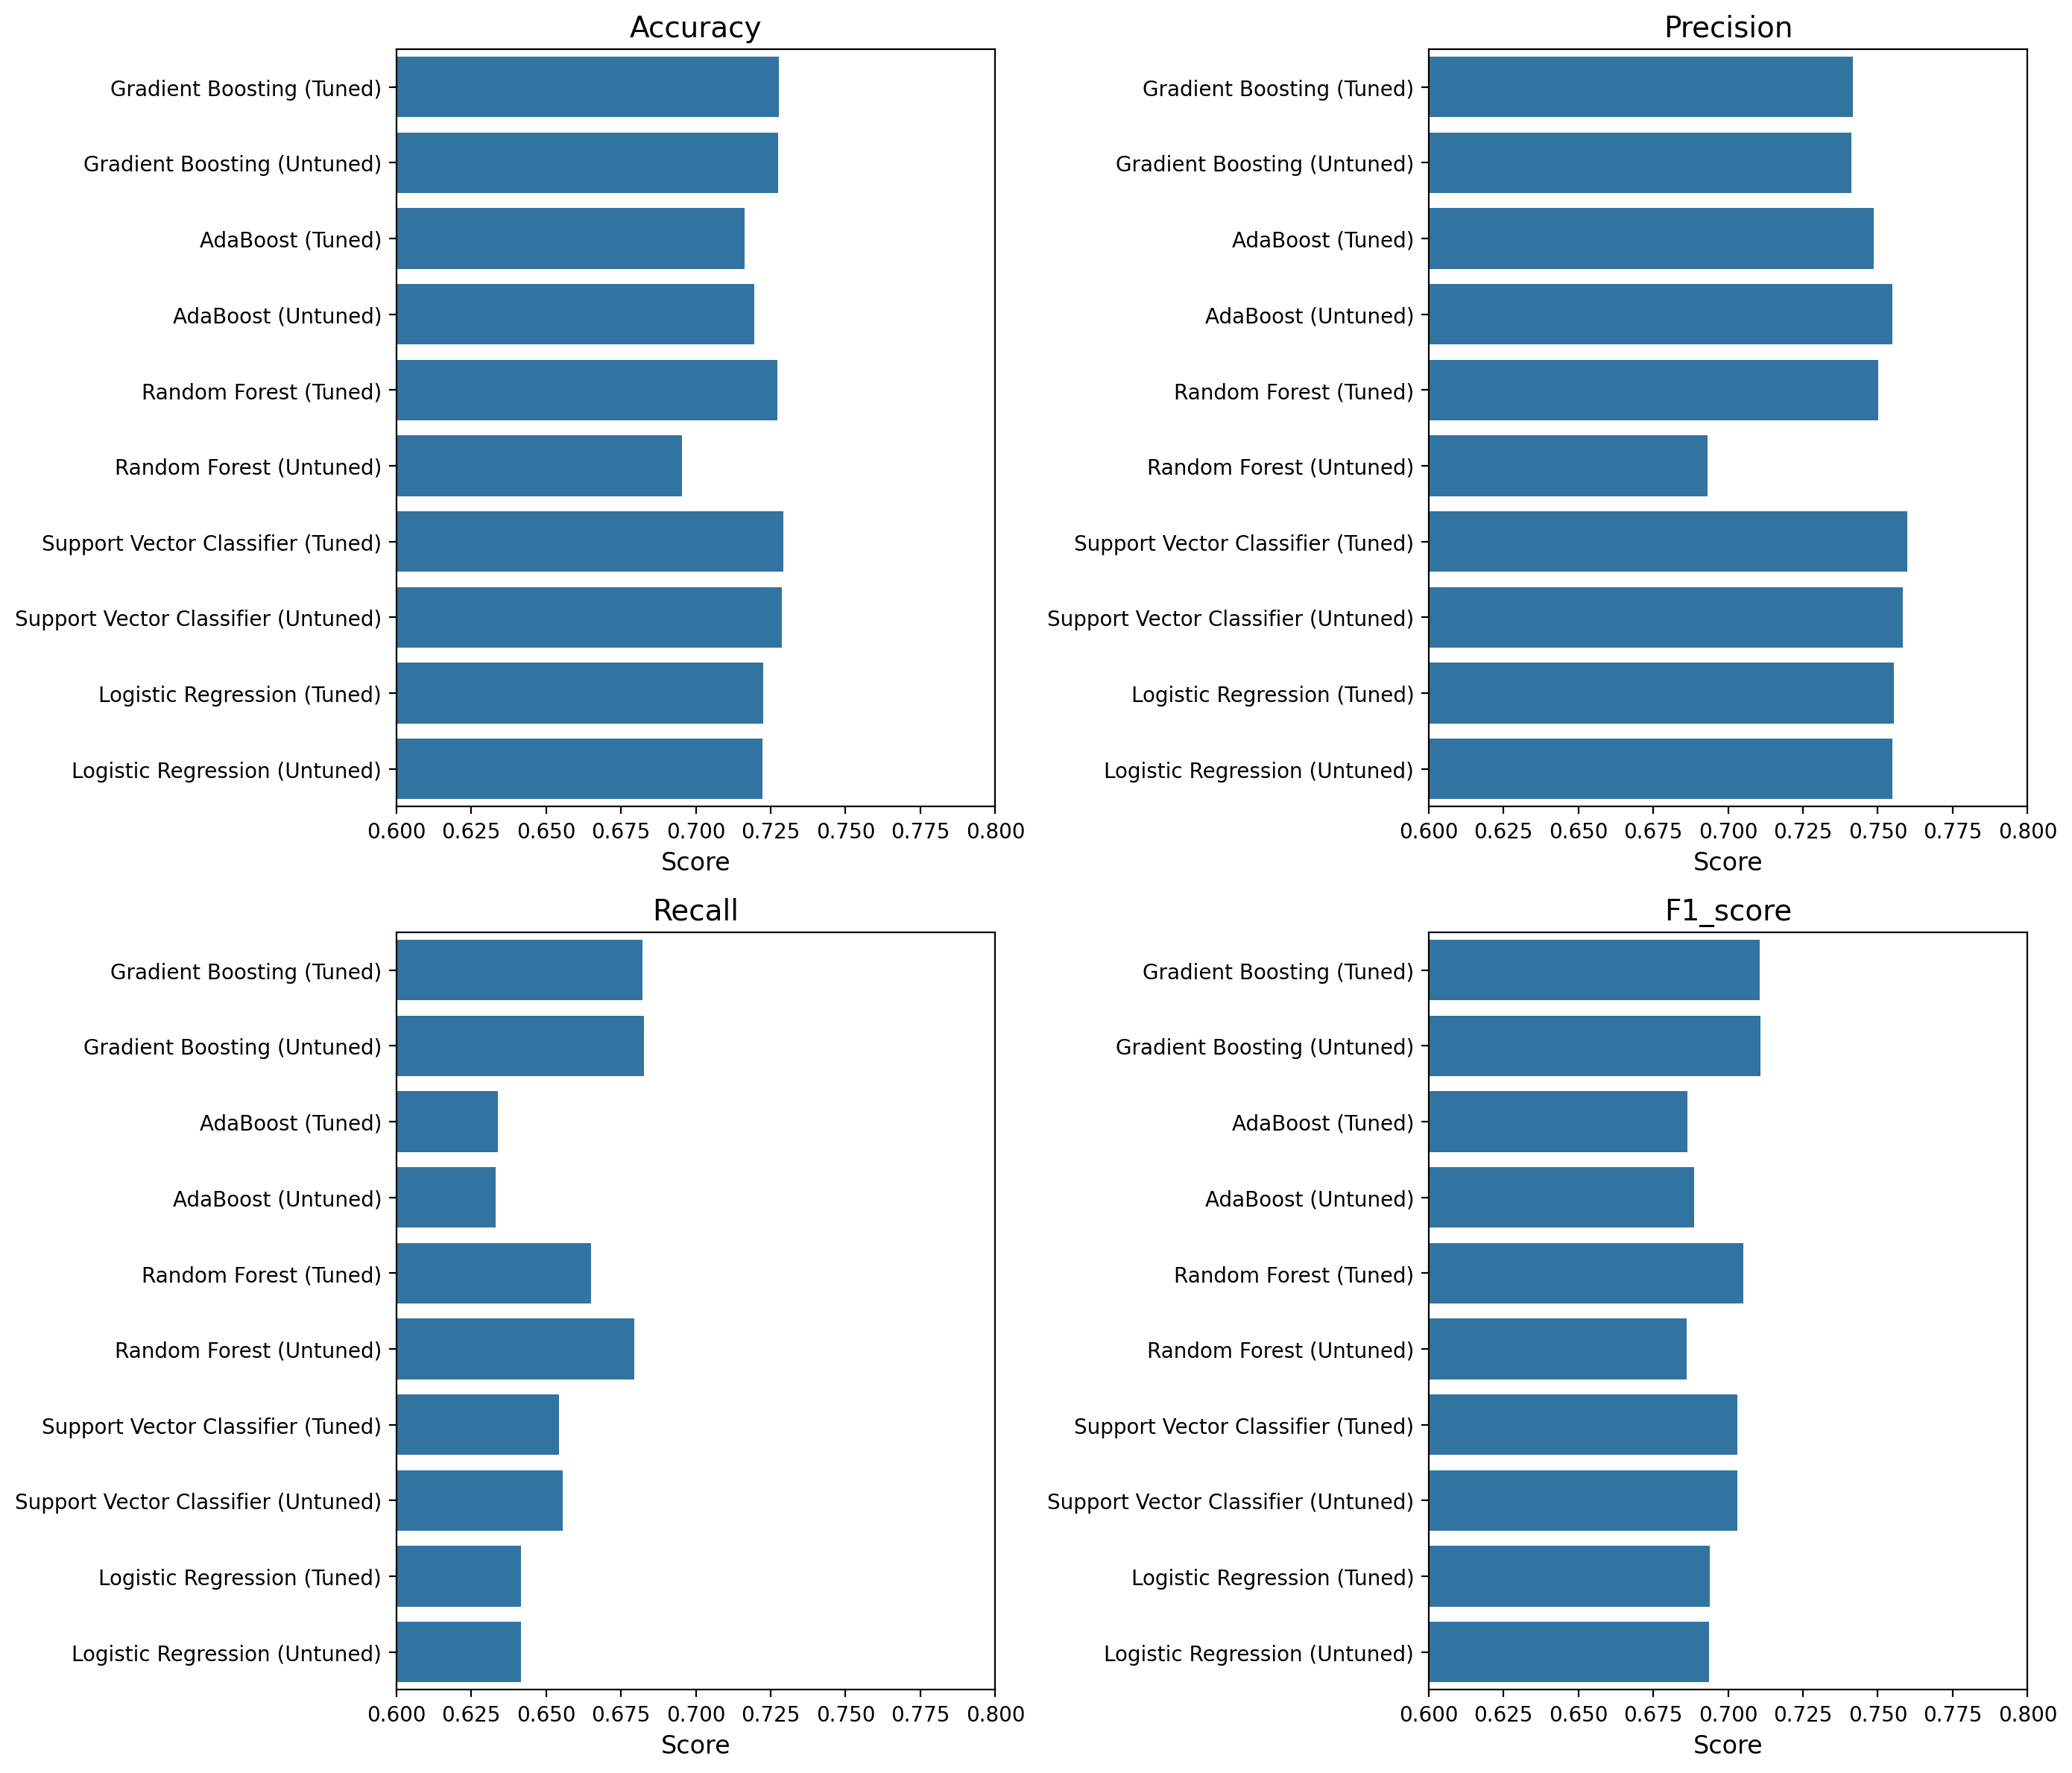

In [6]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
fig,axes = plt.subplots(2, 2, figsize=(14, 12), dpi=200)
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(y='model', x=metric, data=df_results, ax=axes[i])
    axes[i].set_title(metric.capitalize(), fontsize=14)
    axes[i].set_xlim(0.6, 0.8)
    axes[i].set_xlabel('Score', fontsize=12)
    axes[i].set_ylabel('') 
    axes[i].invert_yaxis()
plt.tight_layout()

There are distinct patterns in performance that we observe across the models, both before and after hyperparameter tuning. 

#### Effects of Hyperparameter Tuning

- Gradient Boosting: The differences were very minor; tuning yielded marginal gains in accuracy and precision, but slight drops in recall resulting in a negligibly lower F1 score.
- AdaBoost: The AdaBoost model actually had slightly worse performance in both accuracy and precision after tuning. It's possible that the model overfitted to the training data.
- Random Forest: While tuning led to a slight decrease in the recall score from ~0.679 to ~0.666, it also led to a larger increase in accuracy, from ~0.6955 to ~0.7275, and precision, from ~0.6931 to ~0.7498, leading to an increase in F1 score by nearly 2%, which is a significant benefit.
- SVC: There were small improvements to accuracy and precision, but a slight drop in recall.
- Logistic Regression: Performance before and after tuning remained essentially unchanged.

Random Forest benefited the most from tuning. For Gradient Boosting, Logistic Regression, and SVC, tuning brought only minor changes. AdaBoost actually performed worse after hyperparameter tuning.

#### Metric-Specifics

- Precision: SVC models achieved the highest precision (~0.759) which indicates fewer false positives. However, recall was lower than Gradient Boosting which makes SVC slightly less balanced.
- Recall: Gradient Boosting (both untuned and tuned) had the highest recall (~0.682), meaning it was best at identifying true positives.
- F1 Score: Gradient Boosting stood out with the highest scores (~0.710) confirming it offers the best precision to recall tradeoff.


### Best Overall Model

In terms of the best performing model overall, the __Gradient Boosting model, both untuned and tuned,__ stands out. 
- It has the highest accuracy at 0.7277 (tuned) and 0.7276 (untuned)
- While it has a lower precision score of 0.741 compared to most of the other models, it balances with having the highest recall score of 0.682, thus having the highest F1 score across the models.




# Feature Importances & Interpretation

Let's move on to analyzing each model's feature importance to understand which features contributed the most to model predictions overall. We'll be interpreting feature importances using three different methods:
- Coefficients from Logistic Regression
- Built in feature importances from tree-based models (Random Forest, AdaBoost, and Gradient Boosting)
- Permutation importance for models where directly accessing coefficients or feature importances isn't available (SVC)

We'll need to import the saved data for each model so we can visualize and compare which features were most predictive overall, as well as drawing connections.

In [7]:
filenames_imp = {
    'logistic_regression': {
        'untuned': 'feature_importances/logistic_regression_coefficients.pkl',
        'tuned': 'feature_importances/logistic_regression_tuned_coefficients.pkl'},
    'svc': {
        'untuned': 'feature_importances/svc_permutation.pkl',
        'tuned': 'feature_importances/svc_tuned_permutation.pkl'},
    'random_forest': {
        'untuned': 'feature_importances/random_forest_feature_importance.pkl',
        'tuned': 'feature_importances/random_forest_tuned_feature_importance.pkl'},
    'adaboost': {
        'untuned': 'feature_importances/adaboost_feature_importance.pkl',
        'tuned': 'feature_importances/adaboost_tuned_feature_importance.pkl'},
    'gradient_boosting': {
        'untuned': 'feature_importances/gradient_boosting_feature_importance.pkl',
        'tuned': 'feature_importances/gradient_boosting_tuned_feature_importance.pkl'}
}

feature_importances = {}

In [8]:
for model_name, paths in filenames_imp.items():
    feature_importances[model_name] = {}
    for version, path in paths.items():
        with open(path, 'rb') as f:
            feature_importances[model_name][version] = pickle.load(f)

Now that we've loaded our files containing each model's feature importances, we'll going through each model and observing the differences before and after tuning.

Let's start with visualizing the feature importances from the Logistic Regression models. When saving the feature importances, we also took the absolute value of each of the coefficients to assess importance. We'll be analyzing differences in these values.

### Logistic Regression

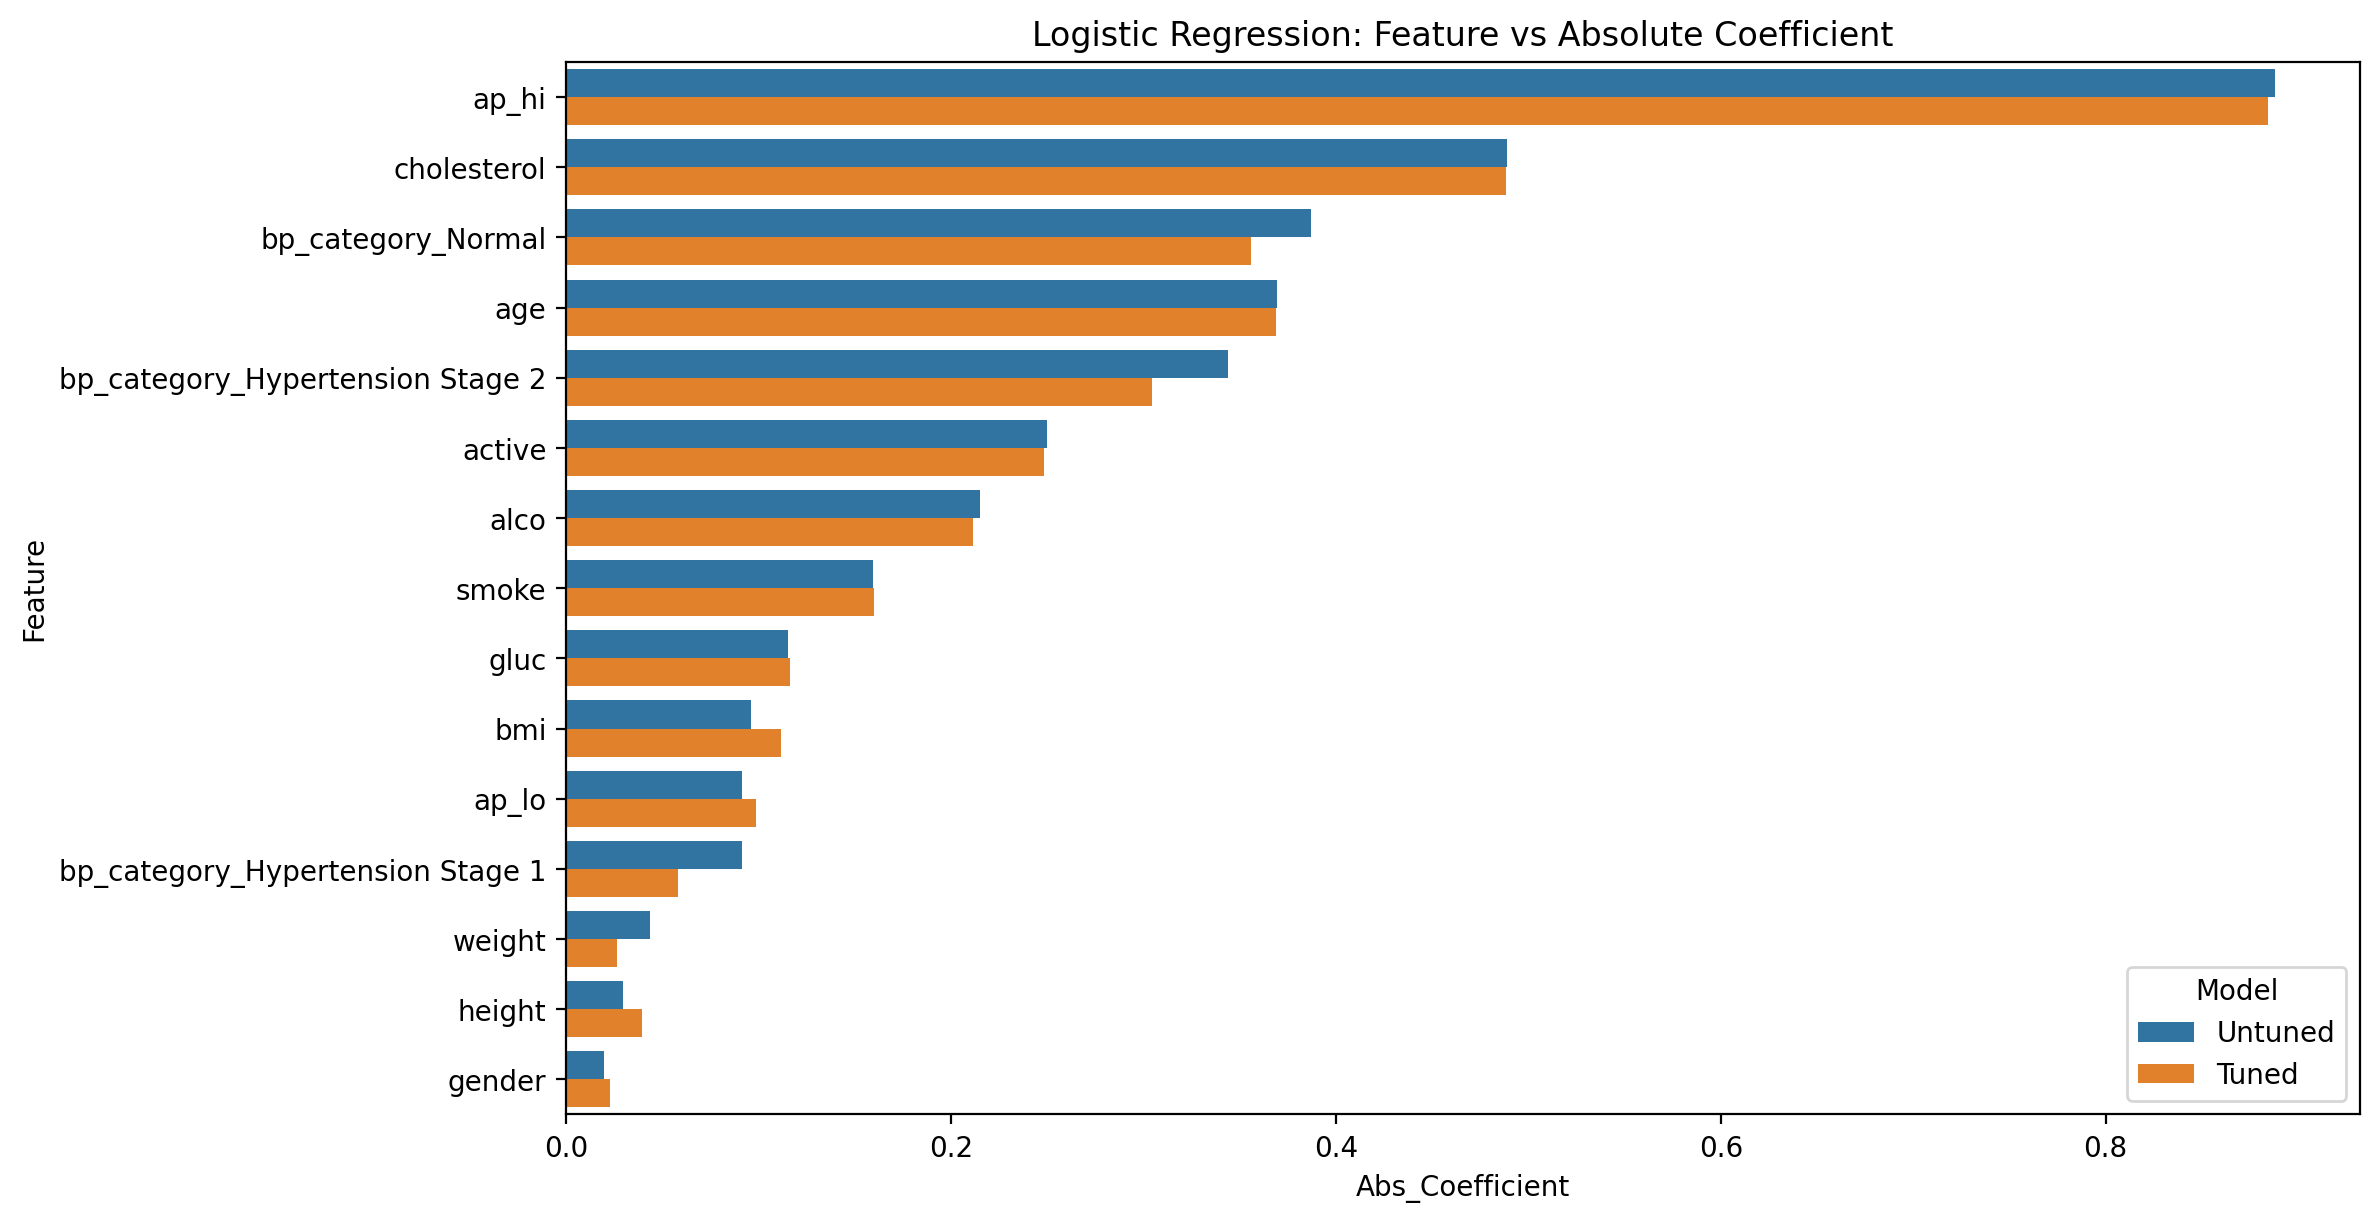

In [44]:
plot_model_importances(feature_importances['logistic_regression'], model_name='Logistic Regression', importance_type='Abs_Coefficient')
plt.title('Logistic Regression: Feature vs Absolute Coefficient');

In both untuned and tuned Logistic Regression models, ap_hi, cholesterol, and bp_category_Normal were top predictors of cardiovascular disease. After tuning, most coefficients slightly decreased in magnitude, which may be due to stronger regularization. Despite this, feature rankings stayed largely the same. Less informative features like gender, height, and weight remained negligible.

Let's move on to analyzing permutation importances of the Support Vector Classifier model. As stated previously, permutation importances don't directly assign a number in terms of model coefficients, but instead it evaluates how much the performance of the model drops when the value of the feature is randomly shuffled across the dataset, or in our case, a sample of the dataset. This gives us an idea of the relative importance of the feature based on its impact on predictive accuracy.

### SVC

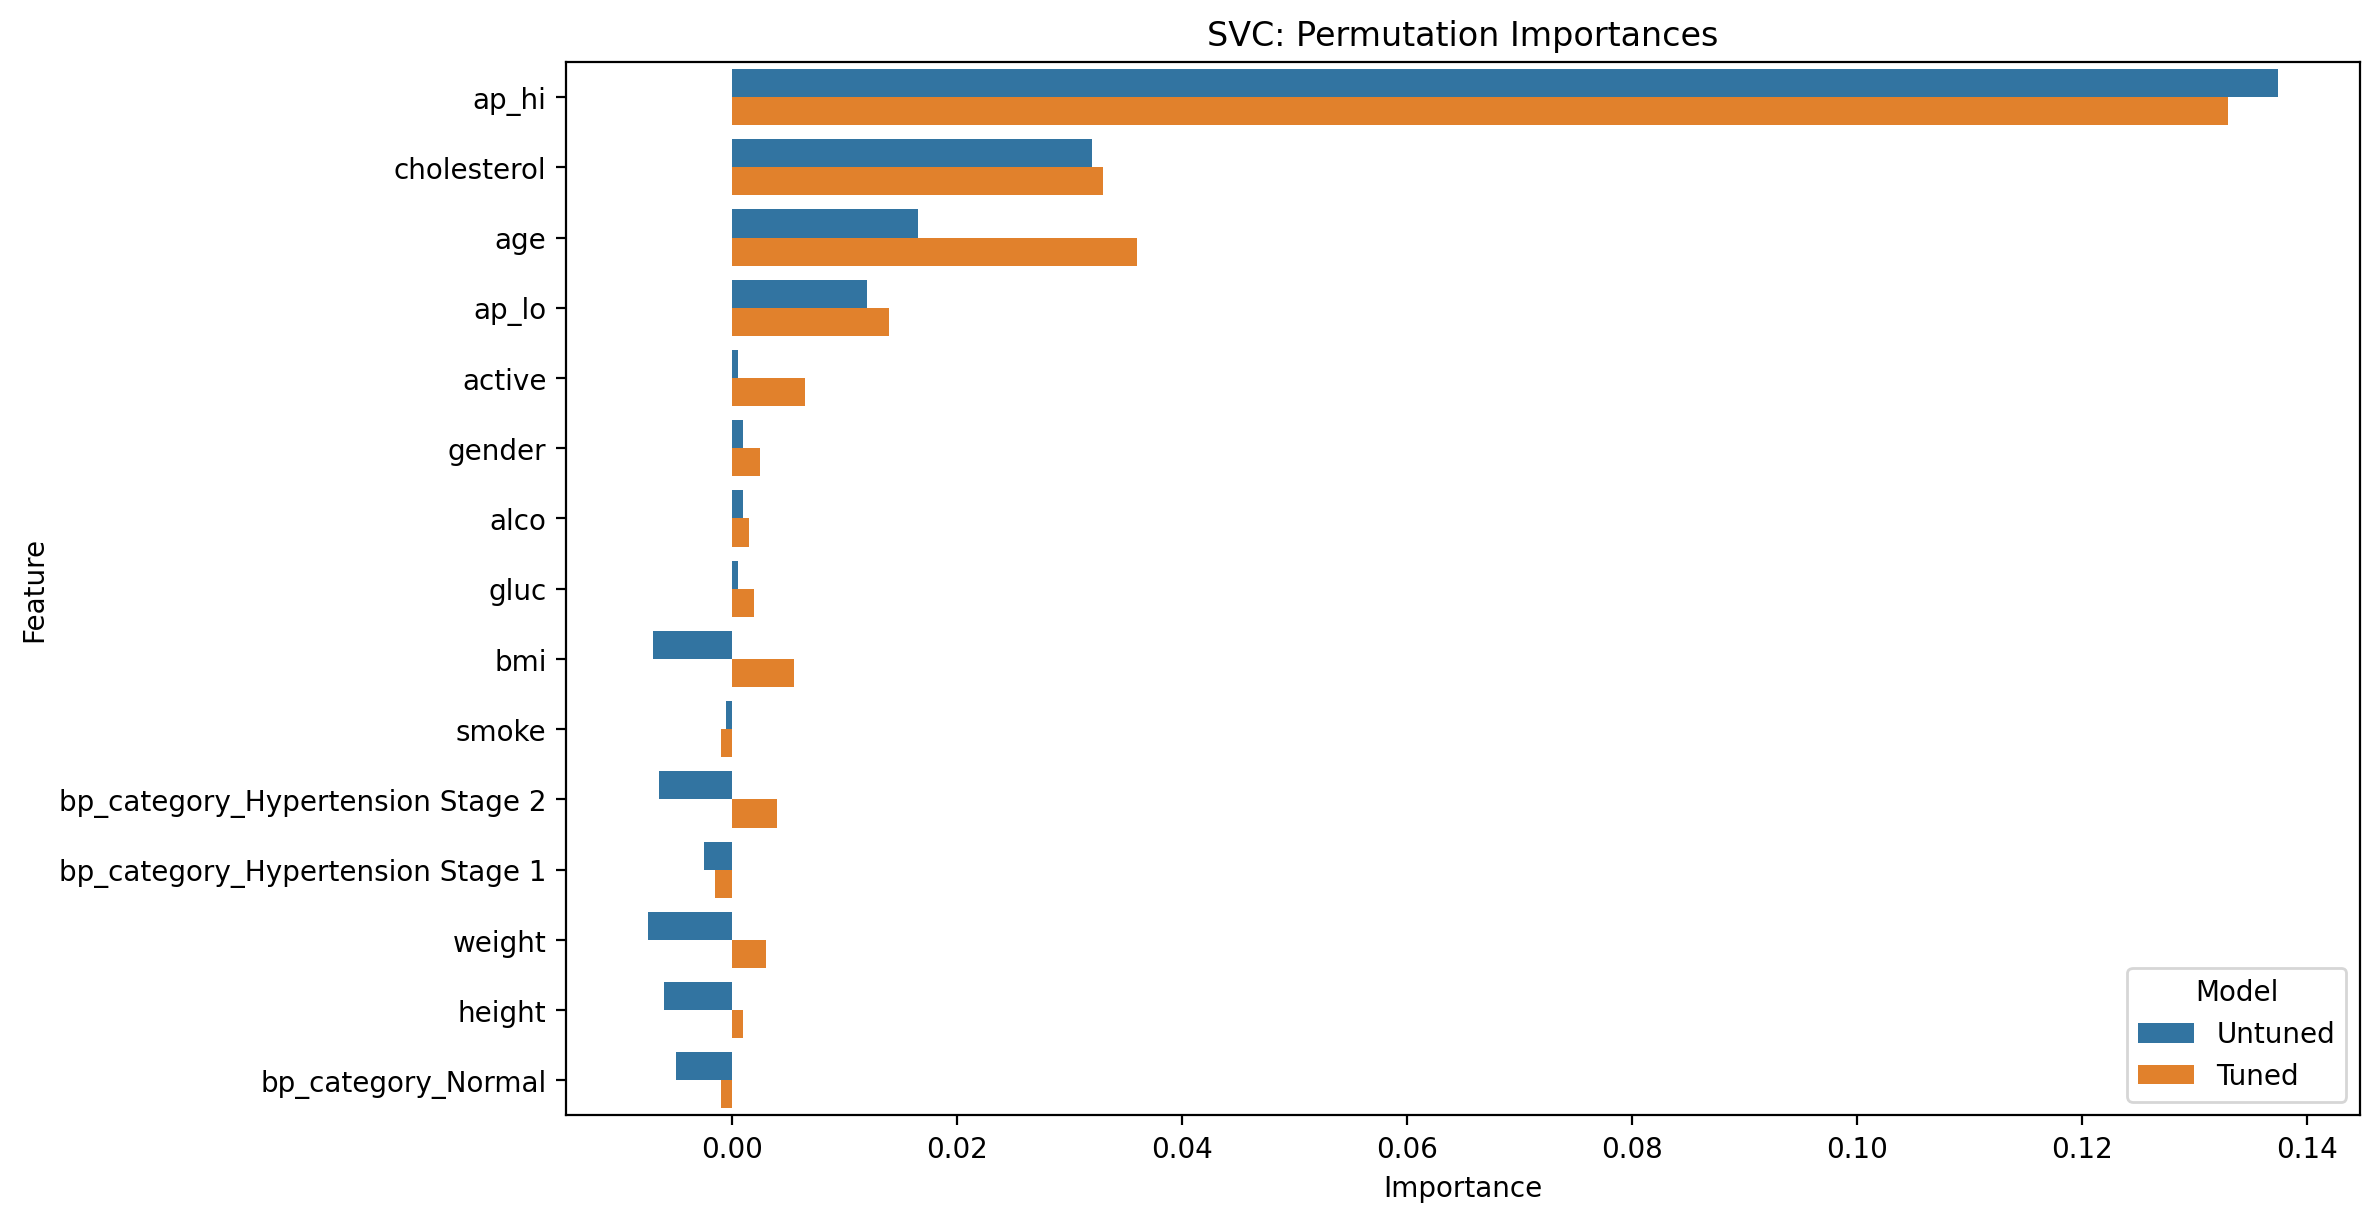

In [48]:
plot_model_importances(feature_importances['svc'], model_name='SVC', importance_type='Importance')
plt.title('SVC: Permutation Importances');

In both the untuned and tuned models, ap_hi and cholesterol remained the most influential features. After tuning, we see that features like age and active gained significant importance compared to the untuned model, likely due to improved hyperparameters that might have allowed the model to capture more subtle patterns. This might mean the model because more sensitive to a broader range of predictors. Across the board, we see an increase in the importance of most demographic and lifestyle features, such as height, weight, bp_category, and bmi.

Let's now analyze tree-based models and their feature importances. We'll take a look at each model individually, and then compare them against each other. It's fair to compare them in this way since all three models use the same measure for importance, so we can compare them on equal footing. Let's start with Random Forest.

### Tree-Based Models

#### Random Forest

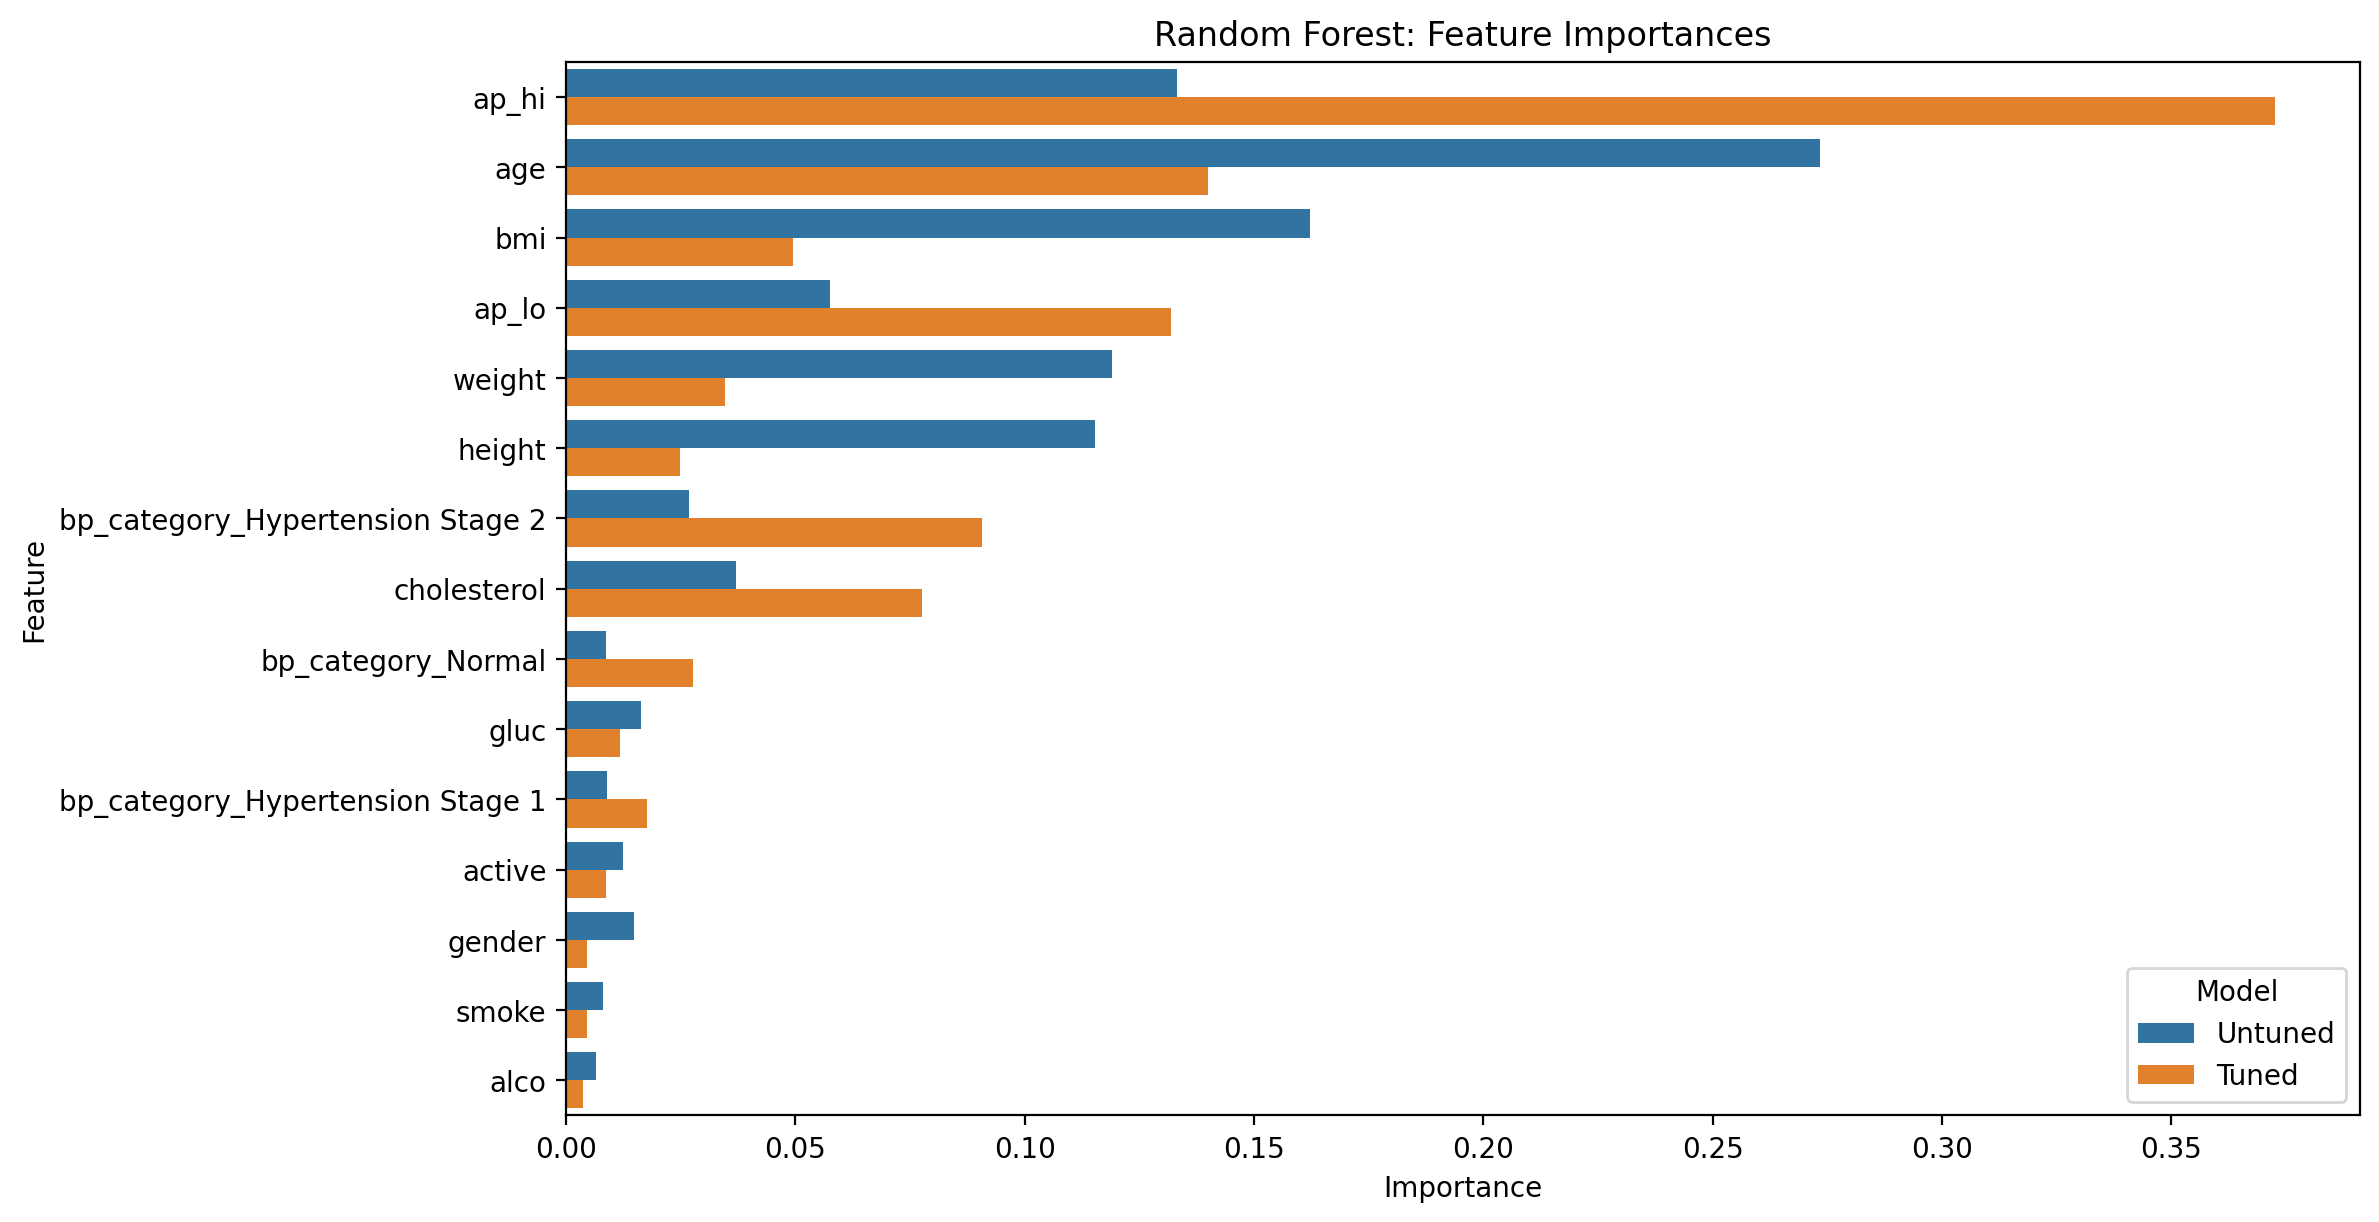

In [49]:
plot_model_importances(feature_importances['random_forest'], model_name='Random Forest', importance_type='Importance')
plt.title('Random Forest: Feature Importances');

In the Random Forest model, tuning led to a major reshuffling of feature priorities. We see features like ap_hi, ap_lo, and bp_category more than doubling in importance, with features like age, bmi, height, and weight consequently halving in importance. This suggests that the tuned model became more focused on direct indicators of cardiovascular health, potentially due to changes in max depth or the features considered at each of the splits.

We'll move on to the Boosted Trees models, looking at them individually, comparing them against each other, and finally analyzing all 3 tree-based models at once.

#### Boosted Trees

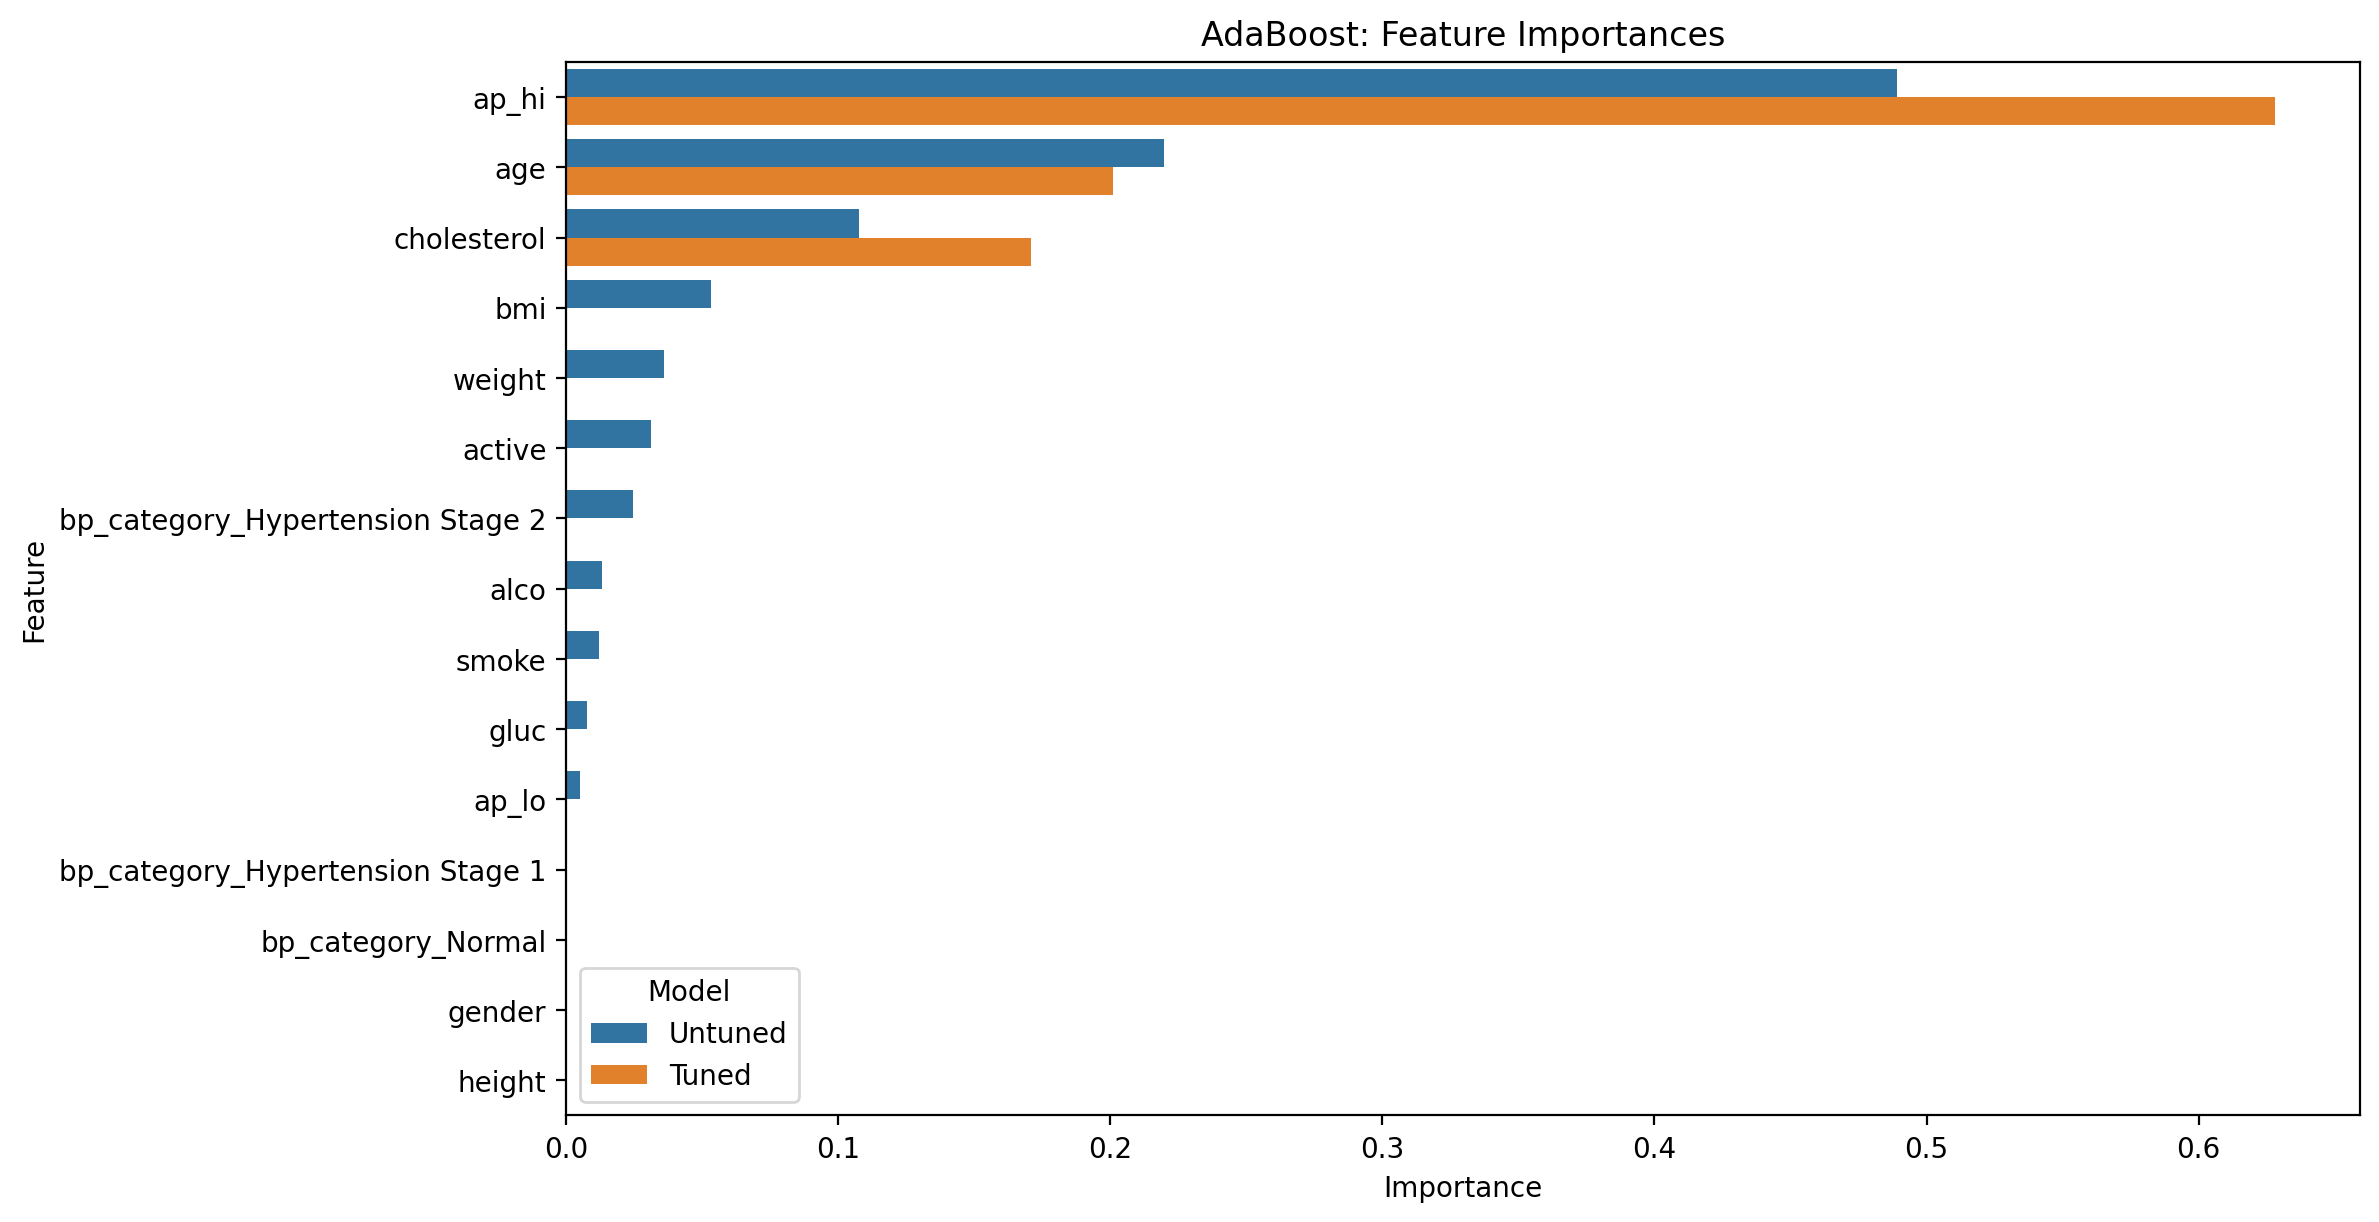

In [50]:
plot_model_importances(feature_importances['adaboost'], model_name='AdaBoost', importance_type='Importance')
plt.title('AdaBoost: Feature Importances');

We see that prior to tuning, the AdaBoost model relies heavily on ap_hi, age, and cholesterol, while also loosely relying on lifestyle features such as alco, smoke, and active. Tuning drastically narrowed the model's focus to just ap_hi, age, and cholesterol, while other featurtes dropped to zero. This suggests that tuning heavily penalized weaker learners and prioritized fewer but more efficient splits.

Let's now take a look at the Gradient Boosting model. Like AdaBoost, it might also emphasize a smaller subset of higher-impact features. But let's see how they might handle feature selection and refinement differently.

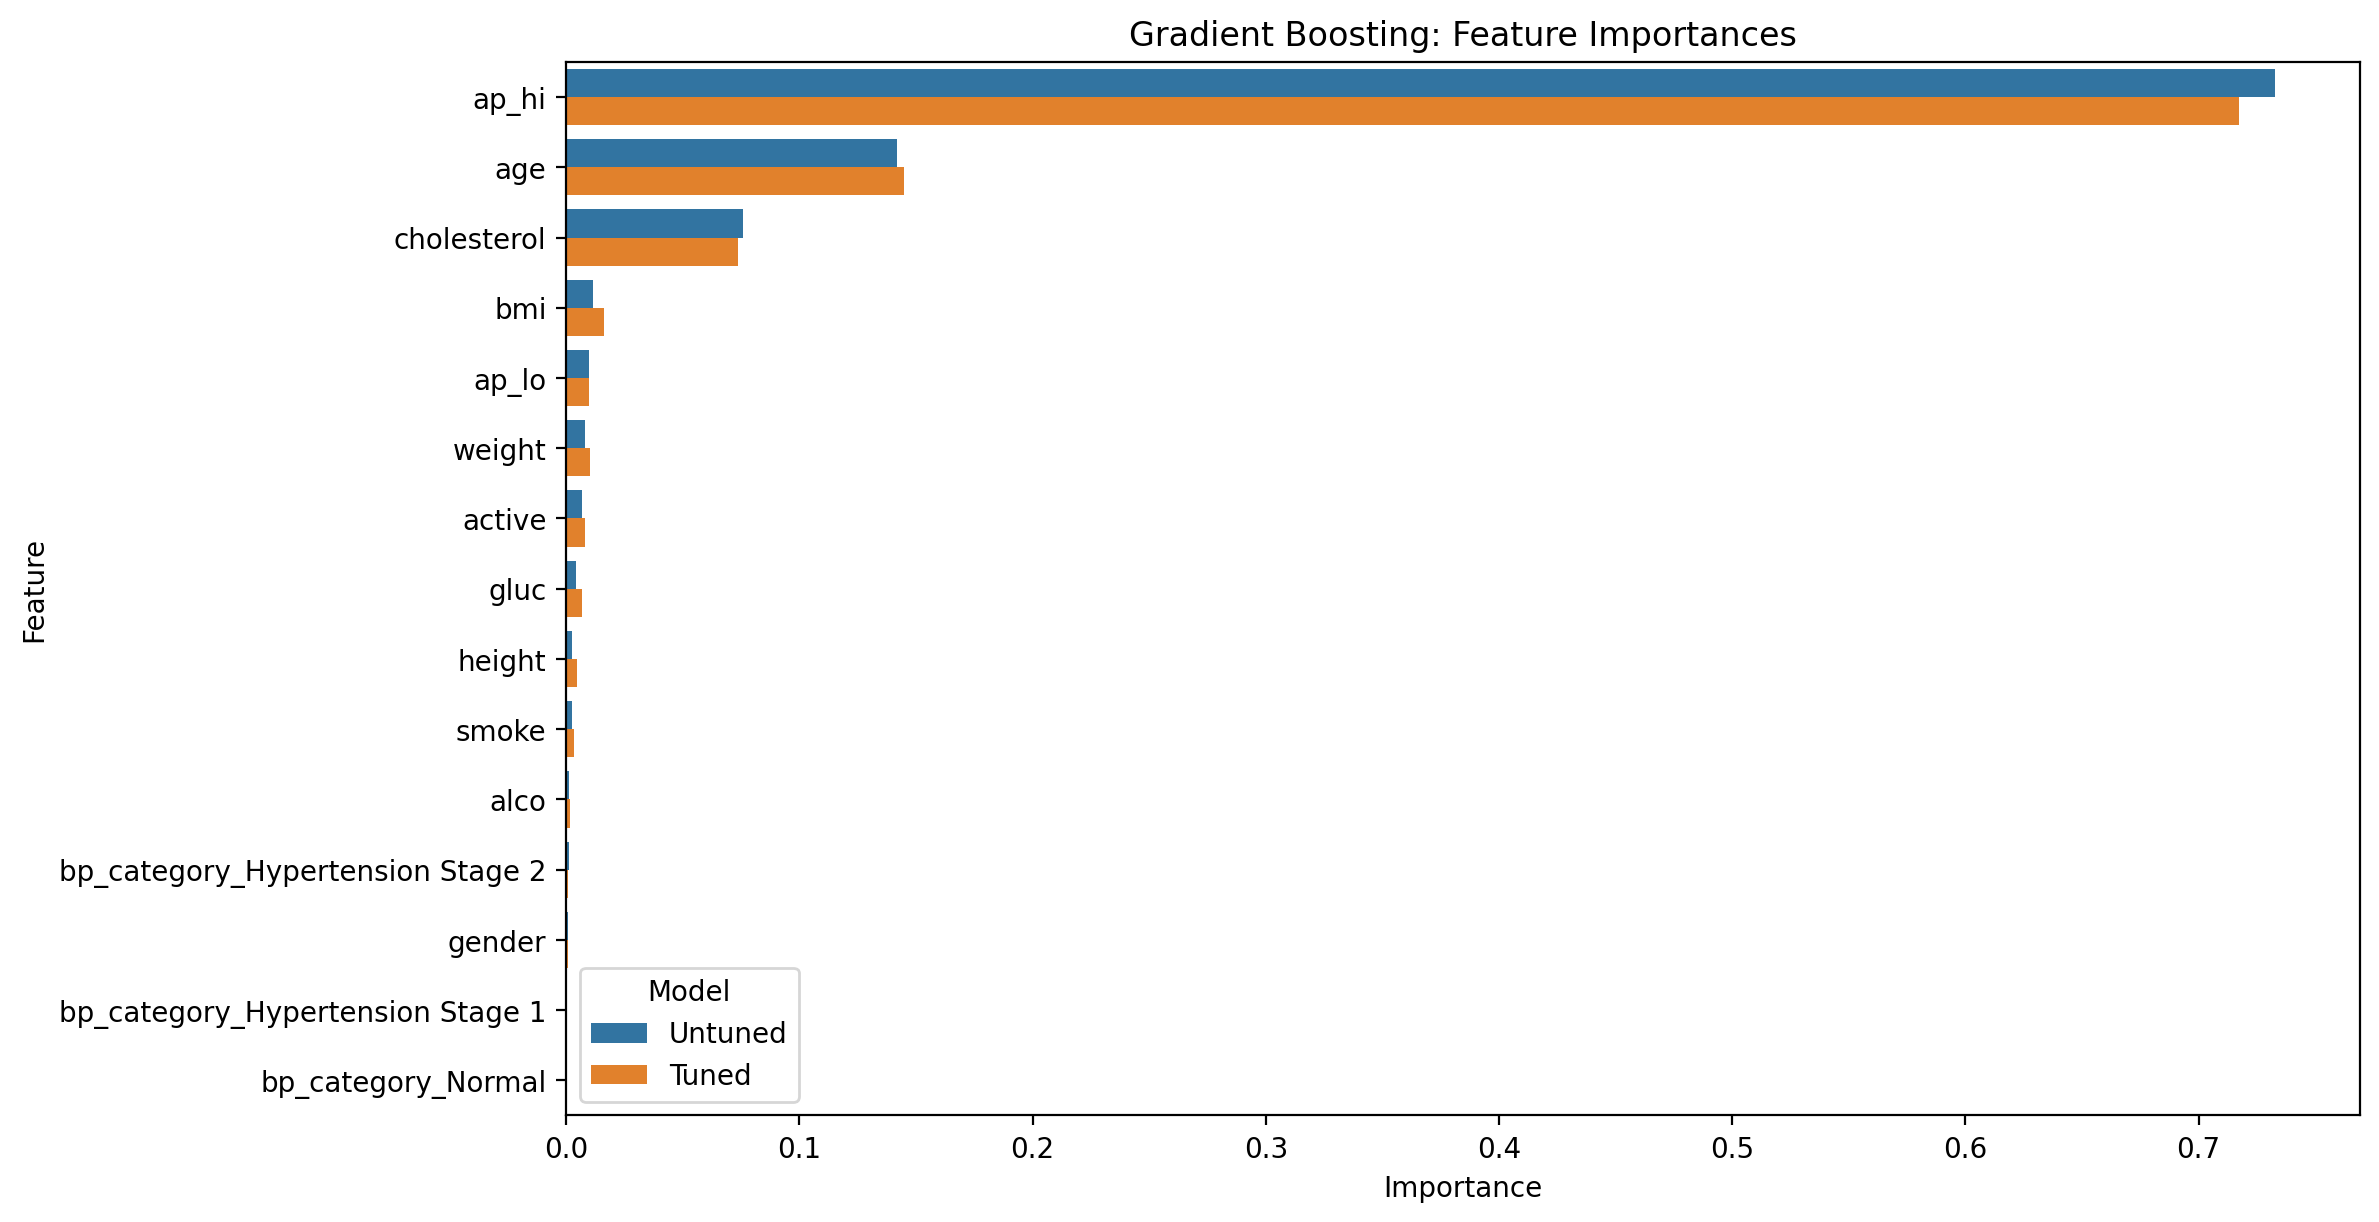

In [51]:
plot_model_importances(feature_importances['gradient_boosting'], model_name='Gradient Boosting', importance_type='Importance')
plt.title('Gradient Boosting: Feature Importances');

As expected, Gradient Boosting shows a strong concentration of importance in only a few features, ap_hi, age, and cholesterol. Tuning marginally reduces the influence of ap_hi, but overall the model continues to rely heavily on the top three.

Let's directly compare AdaBoost and Gradient Boosting. Both models rely heavily on a few key features, but let's see how they differ in prioritizing features and responding to tuning.

In [56]:
plot_models = ['adaboost', 'gradient_boosting']
frames = []

for model in plot_models:
    for version in ['untuned', 'tuned']:
        df = feature_importances[model][version].copy()
        df['Model'] = model
        df['Version'] = version.capitalize()
        frames.append(df)

plot_df = pd.concat(frames, ignore_index=True)

<Figure size 2400x1600 with 0 Axes>

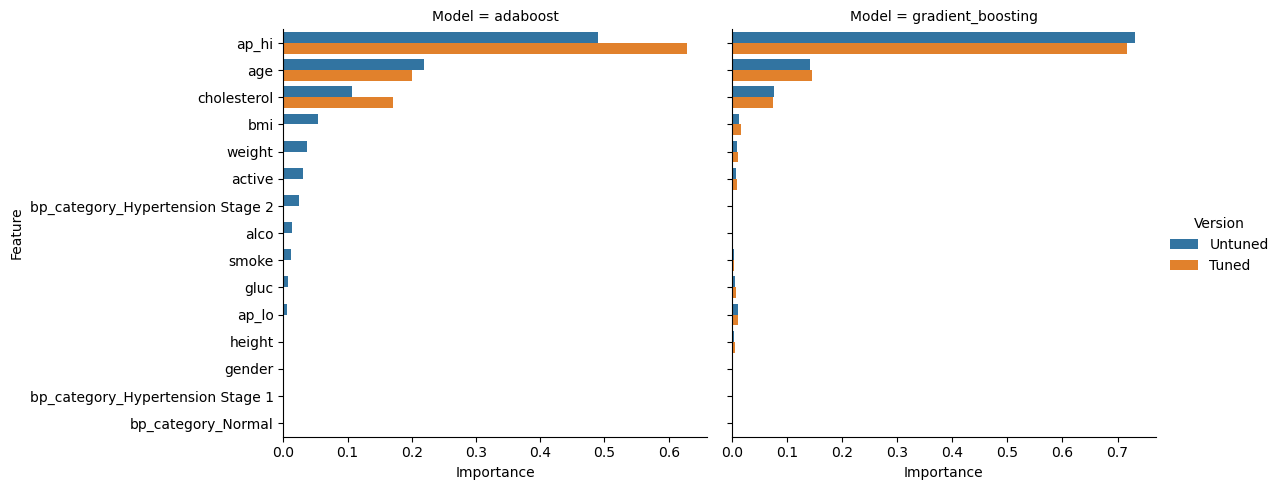

In [57]:
plt.figure(figsize=(12,8), dpi=200)
sns.catplot(data=plot_df, x='Importance', y='Feature', hue='Version', col='Model',kind='bar', height=5, aspect=1.2, sharex=False);

We see that both models overwhelmingly prioritize ap_hi, age, and cholesterol, regardless of tuning. But tuning has different effects on both models. In AdaBoost, tuning greatly increases the importance of ap_hi, pushing it past 0.6. Meanwhile, less important features lose all of their influence, implying that the tuned model becomes more aggressively narrow with only 3 features having influence. Meanwhile, Gradient Boosting has very minimal changes after tuning, with some features slightly increasing or decreasing. While both models prioritize the same features, the effects of tuning are very distinct for both.

Let's take one last look at all tree-based models next to each other, so we can see how Random Forest compares to both boosting methods.

In [58]:
plot_models = ['adaboost', 'gradient_boosting', 'random_forest']
frames = []

for model in plot_models:
    for version in ['untuned', 'tuned']:
        df = feature_importances[model][version].copy()
        df['Model'] = model
        df['Version'] = version.capitalize()
        frames.append(df)

plot_df = pd.concat(frames, ignore_index=True)

<Figure size 1280x960 with 0 Axes>

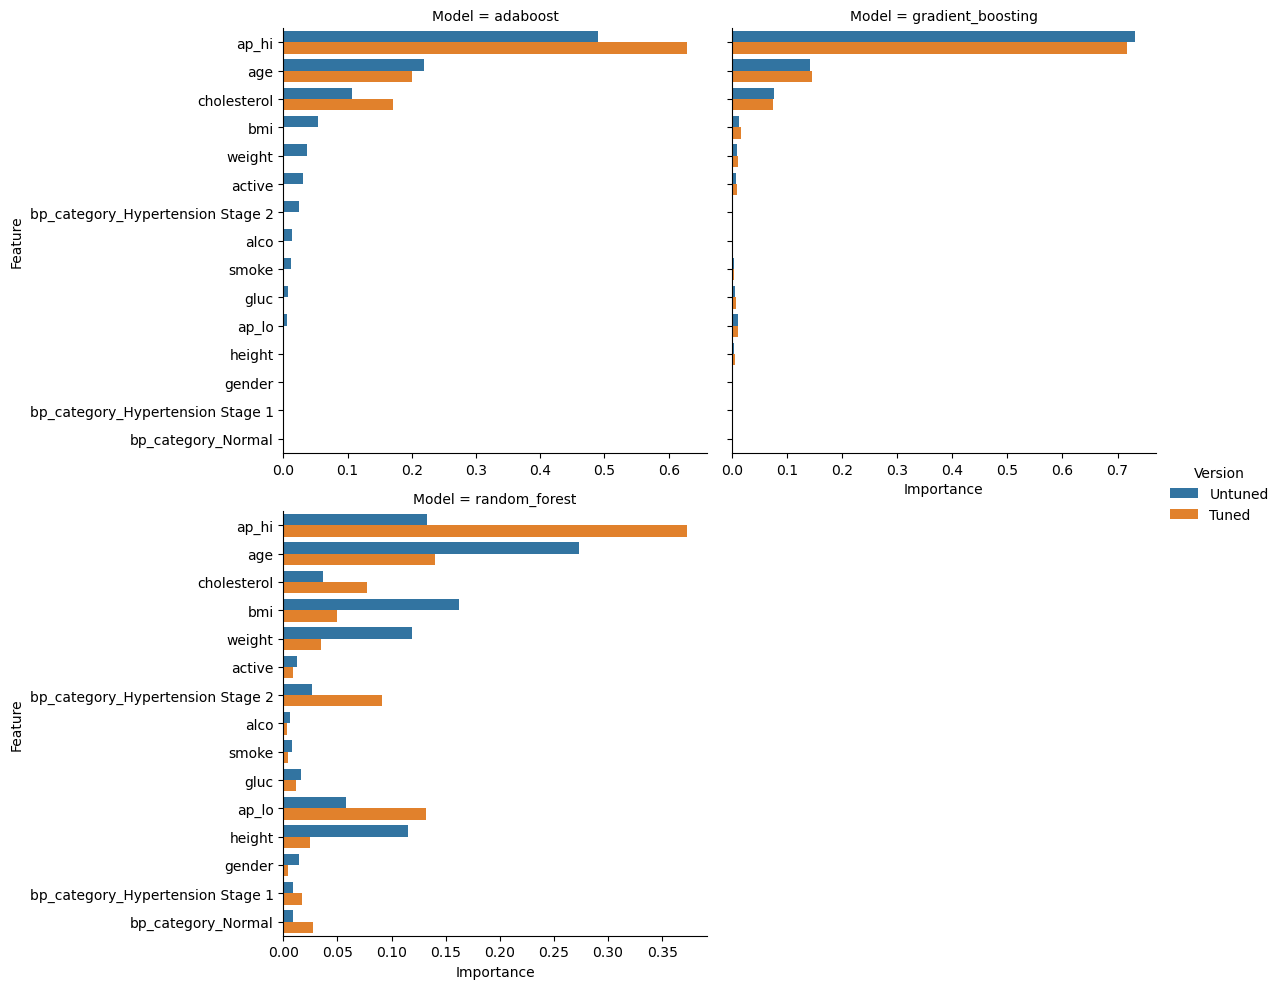

In [59]:
plt.figure(dpi=200)
sns.catplot(data=plot_df, x='Importance', y='Feature', hue='Version', col='Model',kind='bar', height=5, aspect=1.2, col_wrap=2, sharex=False);

We see how Random Forest differs greatly to both Boosted Trees models. While ap_hi, age, and cholesterol have strong influence in all 3 tree-based models, Random Forest prioritizes other features, such as bp_category, bmi, ap_lo, as well as height and weight. Both the untuned and tuned versions show a much more distributed importance pattern. We see how Random Forest is able to leverage significantly more features compare to boosting methods. Random Forest also reacts much more differently to tuning, as seen by the significant shift in the features prioritized. Tuning might have allowed it to redistribute attention to secondary features that were overlooked.